In [63]:
import re
import os
import datetime as dt
import logging
from urllib import request
from urllib.error import HTTPError, URLError

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import boto3
from botocore.exceptions import ClientError
%matplotlib inline

In [64]:
states = '''Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming'''.split('\n')

In [65]:
abbrev_dict = pd.read_html(
                'https://docs.omnisci.com/v4.1.1/3_apdx_states.html',
                header=0)[1].\
                set_index('State').\
                to_dict()['Abbreviation']

In [82]:
def get_folder_name():
    TODAY = dt.datetime.today().strftime('%Y-%m-%d')
    path_for_charts = 'Charts/' + TODAY + '/'
    if not os.path.exists(path_for_charts):
        os.makedirs(path_for_charts)
    return path_for_charts, TODAY

In [68]:
def get_state_data(state, states_data):
    """Takes string state as input and returns a processed dataframe. The data is called from covidtracking.com
        and returns the 'New Tests', 'Cases', 'Negative', 'Hospitalized', 'Deaths', 'Total',
       'Daily Positive', 'Percent Positive', 'Daily Hospitalized',
       'Daily Deaths', '7 Day Rolling', '14 Day Rolling',
       '7 Day Rolling Percent Pos', 'Doubling Time', 'State'"""
    # format state name for covidtracking.com
    # state = state.lower().replace(' ', '-')
    # read historical data table from covidtracking.com and invert the order
    # data is presented most recent to oldest
    df = states_data[states_data.state == abbrev_dict[state]].iloc[::-1].copy()
    # drop irrelevant columns
    #df.drop(['Screenshots (ET)', 'Pending'], axis=1, inplace = True)
    
    # format columns and create features 
    df.date = pd.to_datetime(df.date.astype('str'))
    df.set_index('date', inplace=True)
    df.positive = df.positive.interpolate('linear')
    df['Daily Positive'] = df['positive'].diff(1)
    df['Percent Positive'] = df['Daily Positive'] / df['totalTestResults'] * 100.0
    df['Percent Positive'].fillna(0)
    df['Daily Hospitalized'] = df.hospitalized.diff(1)
    df['Daily Deaths'] = df.death.diff(1)
    # Min periods allows the rolling average to be missing 1-2 values before returning NaN
    df['7 Day Rolling'] = df['Daily Positive'].rolling(window=7, min_periods=5).mean()
    df['14 Day Rolling'] = df['Daily Positive'].rolling(window=14, min_periods=5).mean()
    df['7 Day Rolling Deaths'] = df['Daily Deaths'].rolling(window=7, min_periods=5).mean()
    df['14 Day Rolling Deaths'] = df['Daily Deaths'].rolling(window=14, min_periods=5).mean()
    df['7 Day Rolling Percent Pos'] = df['Percent Positive'].rolling(window=7, min_periods=5).mean()
    # 1st and 2nd Derivatives
    df['Velocity of Daily Cases'] = df['Daily Positive'].diff(1)
    df['Acceleration of Daily Cases'] = df['Velocity of Daily Cases'].diff(1)
    df['Velocity of Daily Deaths'] = df['Daily Deaths'].diff(1)
    df['Acceleration of Daily Deaths'] = df['Velocity of Daily Deaths'].diff(1)
    df['Squared Accleration'] = df['Acceleration of Daily Cases'] ** 2 / df['Acceleration of Daily Cases'].max()
    # 3Blue1Brown
    df['Growth Factor'] = df['Daily Positive'] / df['Daily Positive'].shift(1)
    # doubling time is wrong and needs to be fixed
    df['Doubling Time'] = np.log(2) / np.log(
        1 + (df['7 Day Rolling'] / df.positive)
    )
    df['Doubling Time Deaths'] = np.log(2) / np.log(
        1 + (df['7 Day Rolling Deaths'] / df.positive)
    )
    df['State'] = state.replace('-', ' ').title()
    
    print(f'{state} returned {df.shape[0]} rows')
    
    return df

In [79]:
def state_plots(state, df, close = True, save = True):
    # Return path and today's date as string
    path_for_charts, TODAY = get_folder_name()
    
    # % Daily Positive
    _plot = df[['Percent Positive','7 Day Rolling Percent Pos']].\
        plot(style=['H','-'],
             color=['xkcd:dark blue','xkcd:sky blue'],
             figsize=(15,5),
             title=f'{state} Percent Positive')
    _plot.axhline(0, color='gray', linestyle='--', alpha=0.8)
    _plot.fill_between(df.index,0,5, color='green', alpha=0.3)
    _plot.text(pd.Timestamp('2020-03-09'),1,'Under 5%')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Tests Percent Positive {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Daily Positive
    _plot = df[['Daily Positive','7 Day Rolling','14 Day Rolling']].\
        plot(style=['H','-.',':'],
             color=['xkcd:metallic blue','xkcd:warm pink','xkcd:dark purple'],
             figsize=(15,7),
             title=f'{state} Daily Positive')
    _plot.axhline(0, color='gray', linestyle='--', alpha=0.8)
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Cases Positive {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Total Cases and Tests
    _plot = df[['positive','totalTestResults']].plot(
        style=['-','^'],
        color=['blue','green'],
        figsize=(10,5),
        title=f'Total {state} Cases and Total Tests (Swab/Saliva +)')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Total Cases and Total Tests {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Daily Change Ratio
    _plot = df[['Growth Factor']].plot(
        color='xkcd:navy blue',
        figsize=(10,5),
        title=f'{state} Growth Factor')
    _plot.axhline(1, color='orange', linestyle='-.', alpha=0.8)
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Growth Factor {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Velocity/Acceleration
    _plot = df[['Velocity of Daily Cases', 'Acceleration of Daily Cases']].\
        rolling(window=14, min_periods=7).mean()[::-1].\
        plot(figsize=(15,7),
            title = f'{state} Velocity and Accleration of Daily Cases {TODAY}',
            style=['-',':'],
            linewidth = 3,
            kind='line',
            color = ['xkcd:orange red', 'xkcd:rose pink'],
            alpha = 0.8
            )
    _plot.plot(df.date, df['Daily Positive'])
    _plot.axhline(0,
                    color='gray',
                    linestyle='--',
                    alpha=0.8)
    
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Velocity and Accleration of Daily Cases {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Doubling Time
    _plot = df['Doubling Time'].plot(figsize=(15,7),
        title = f'{state} Cases Doubling Time {TODAY}',
        style=['-'],
        linewidth = 2,
        kind='line',
        color = ['xkcd:orange red'],
        alpha = 0.8
        ).set_ylabel('Days')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Cases Doubling Time {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())

New Jersey returned 284 rows


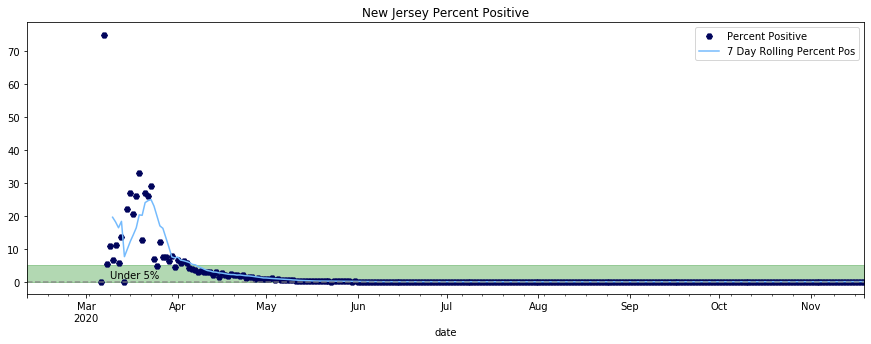

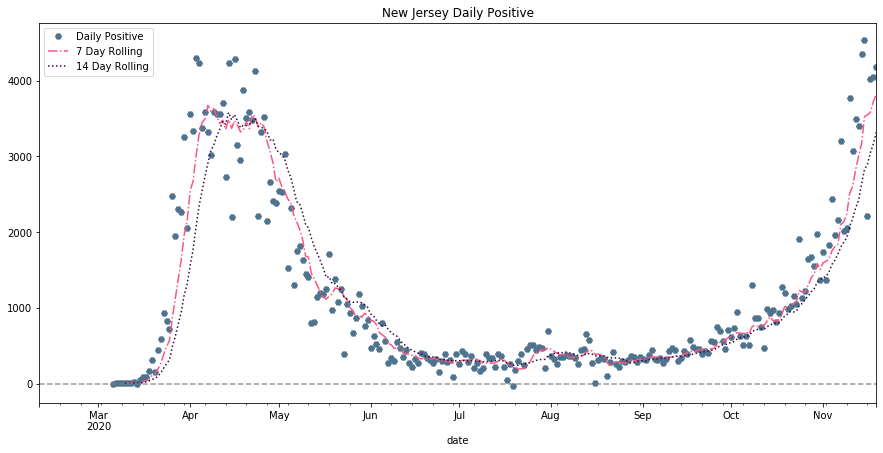

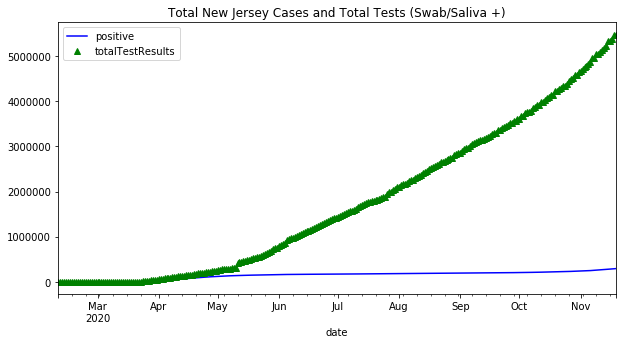

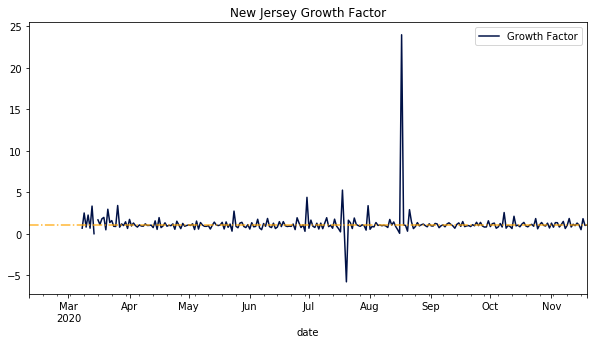

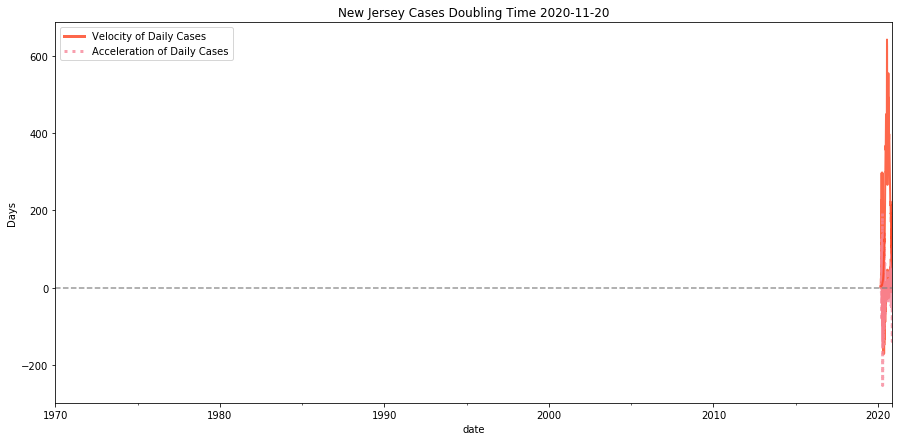

In [80]:
states_data = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv')
state_plots('New Jersey', get_state_data('New Jersey', states_data), close=False, save=False)

New Jersey returned 284 rows


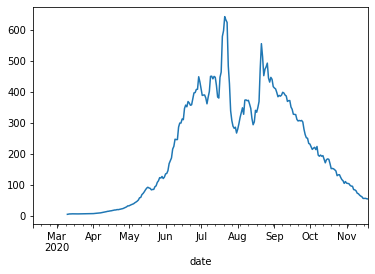

In [76]:
nj = get_state_data('New Jersey', states_data)
nj['Doubling Time'].plot()

Alabama returned 262 rows
Alabama returned 262 rows


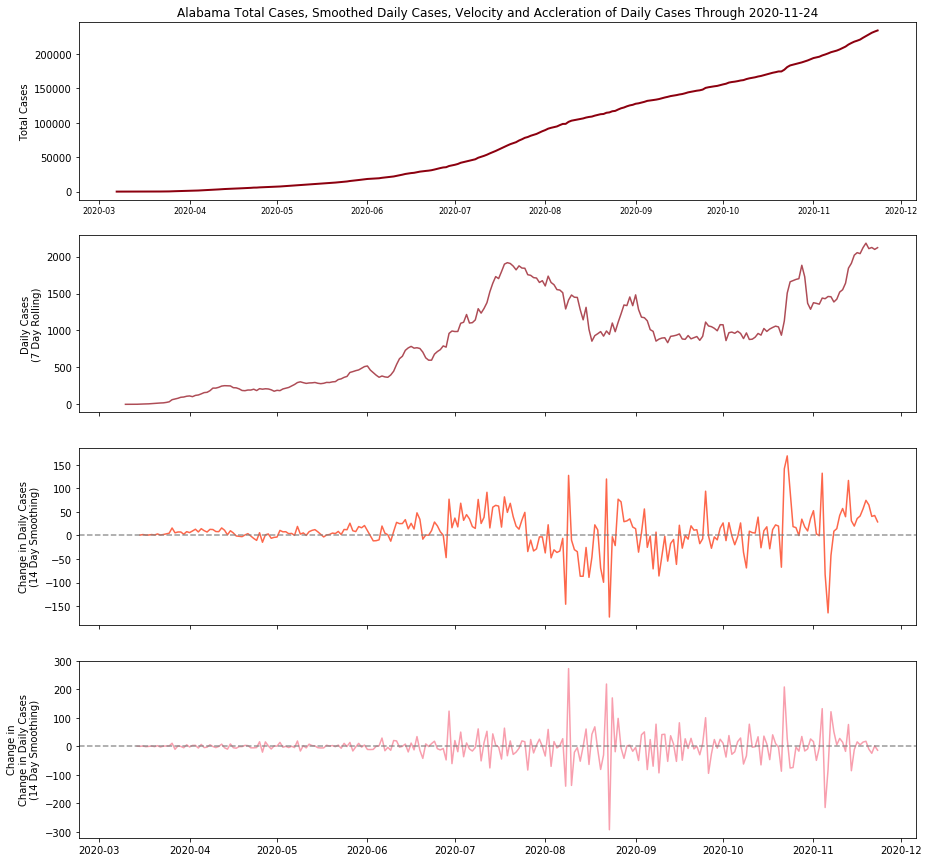

Alaska returned 263 rows
Alaska returned 263 rows


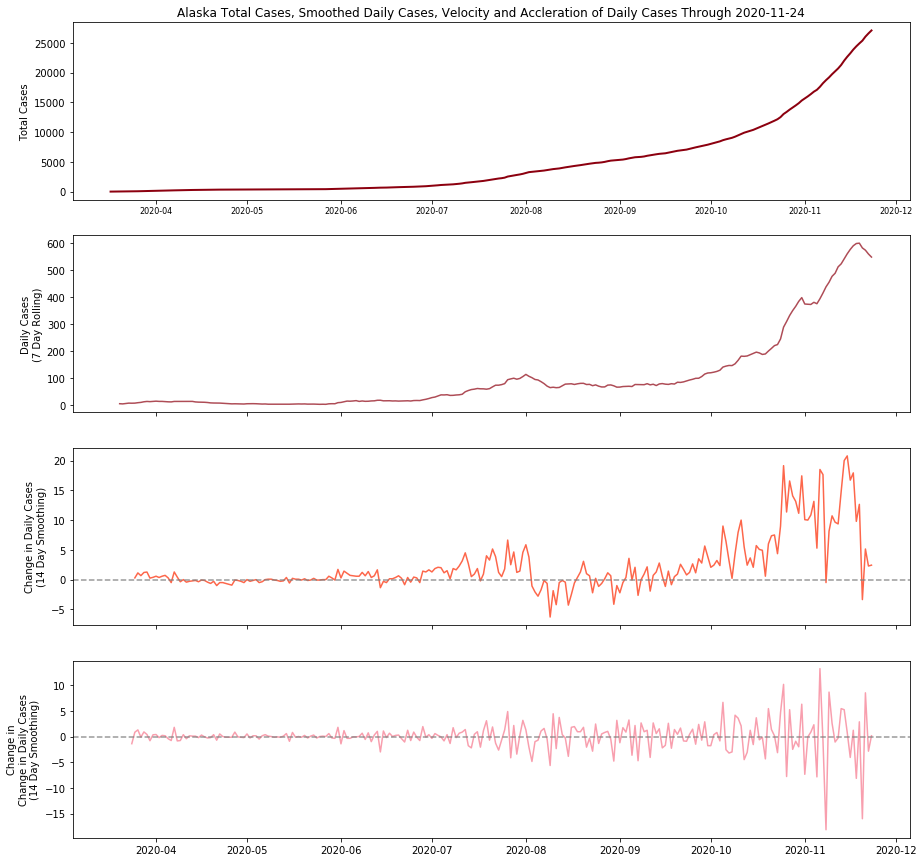

Arizona returned 265 rows
Arizona returned 265 rows


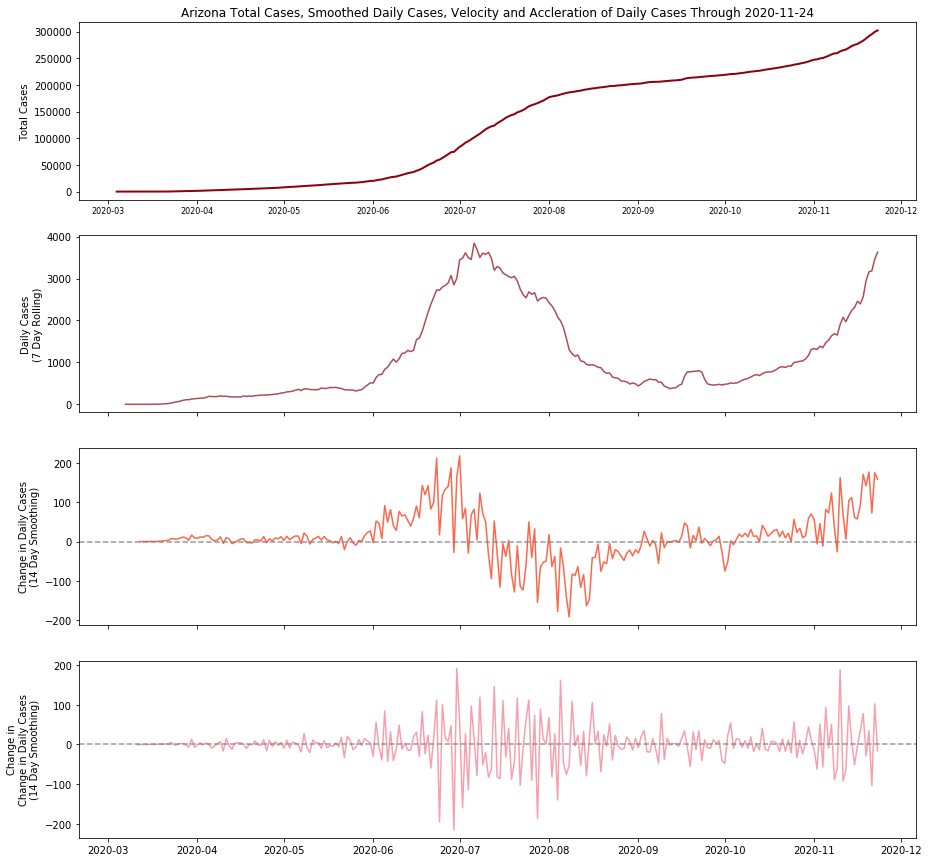

Arkansas returned 263 rows
Arkansas returned 263 rows


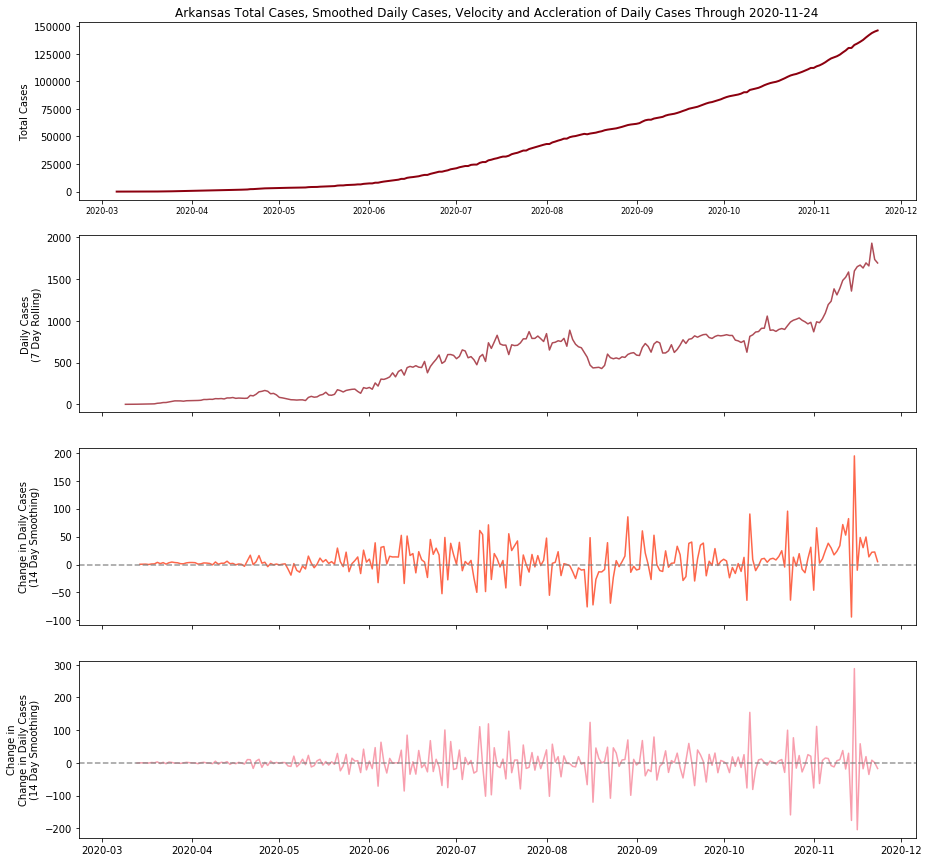

California returned 265 rows
California returned 265 rows


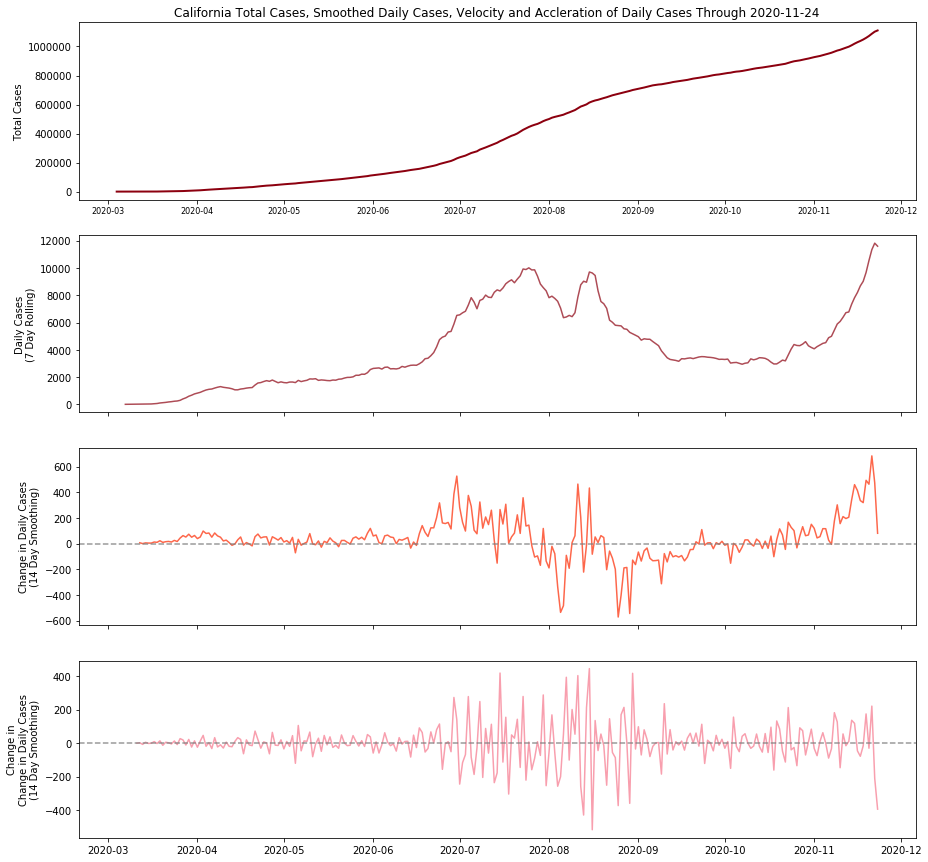

Colorado returned 265 rows
Colorado returned 265 rows


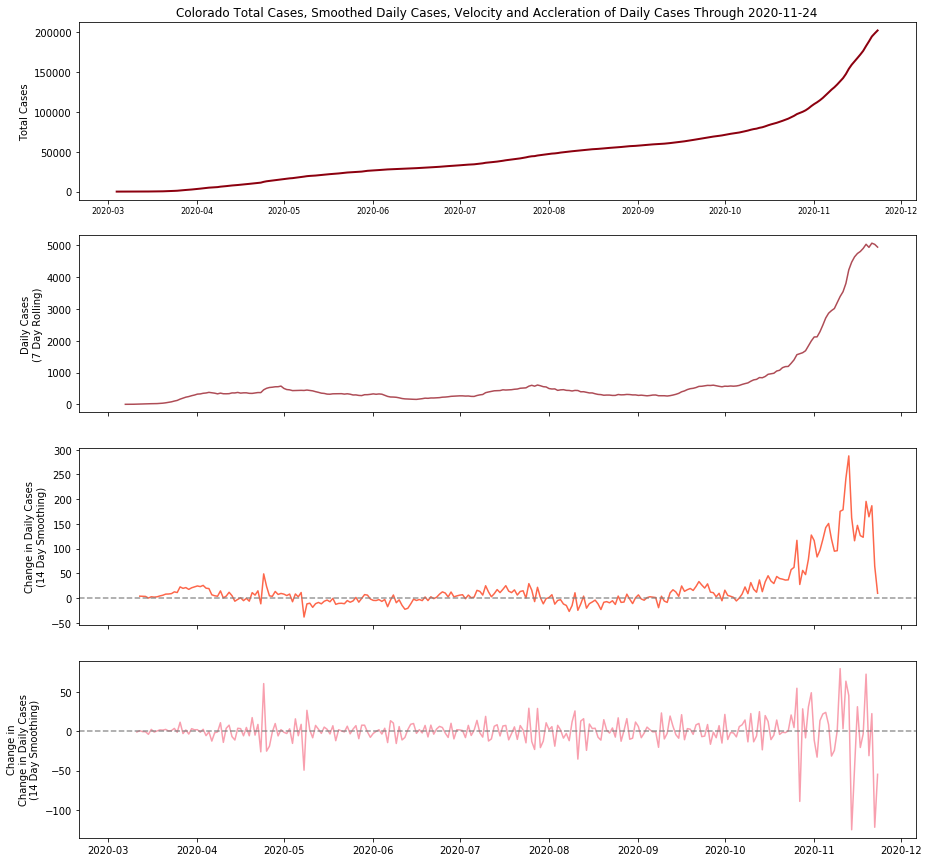

Connecticut returned 262 rows
Connecticut returned 262 rows


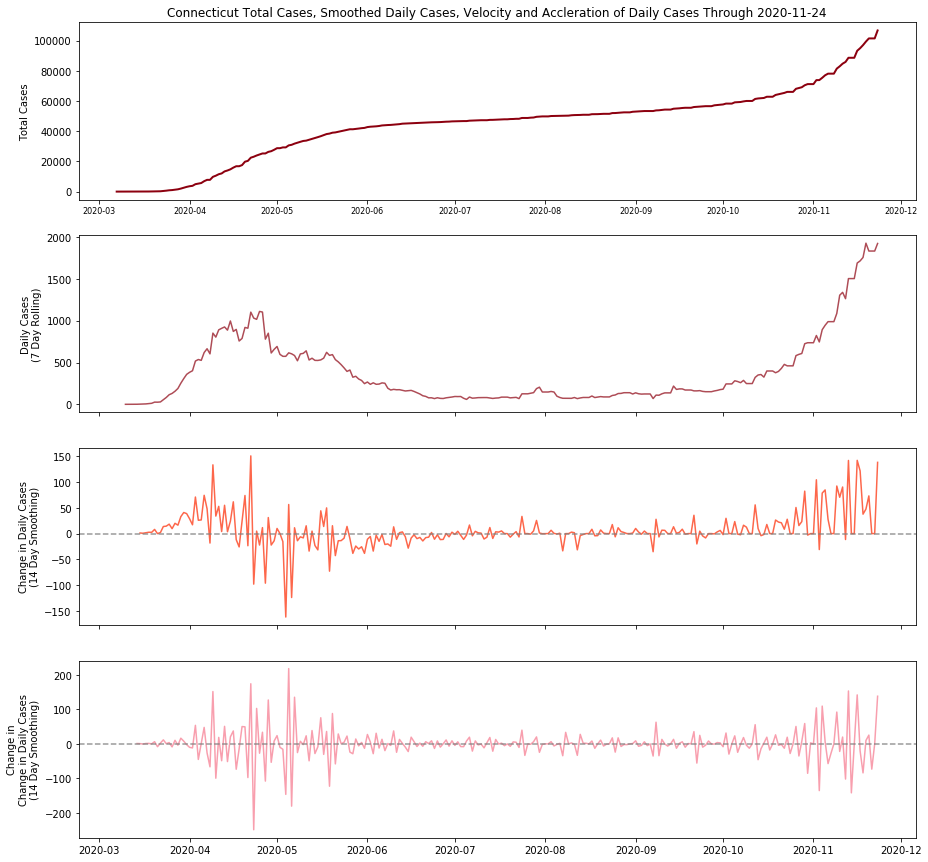

Delaware returned 263 rows
Delaware returned 263 rows


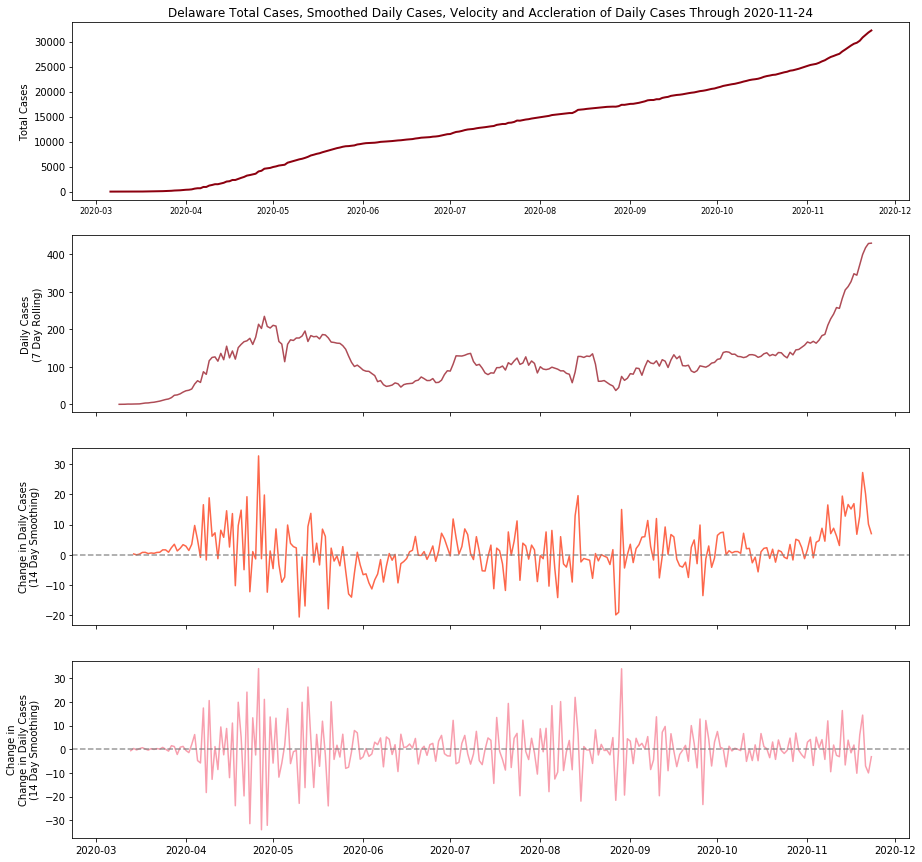

Florida returned 300 rows
Florida returned 300 rows


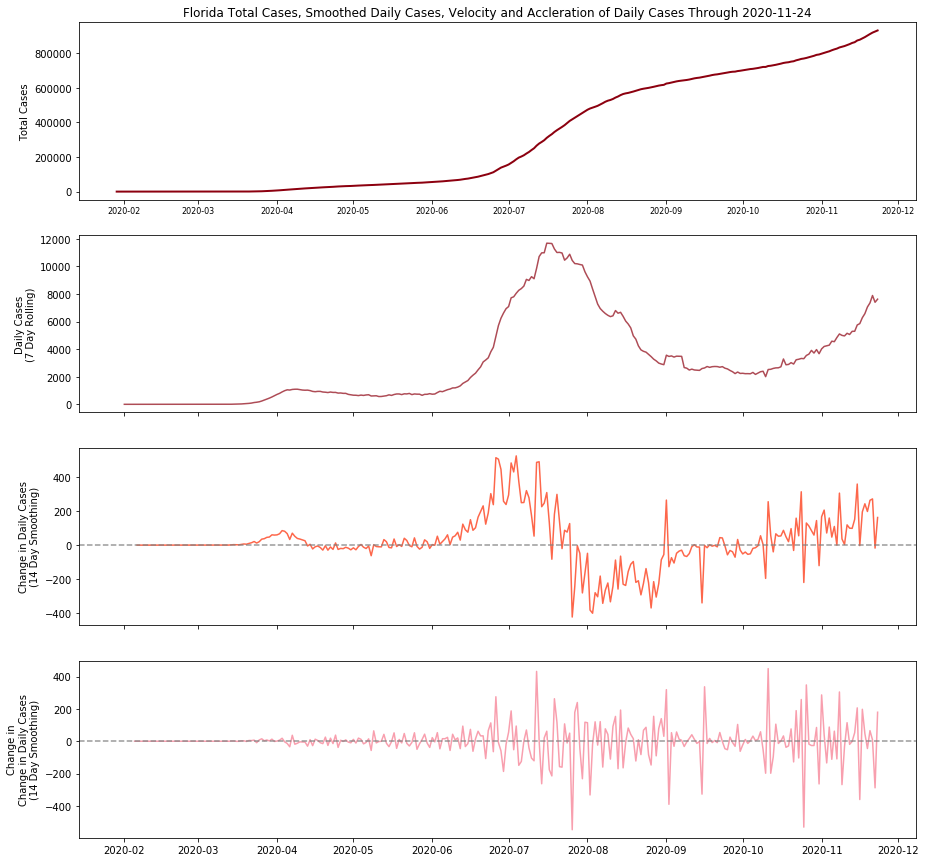

Georgia returned 265 rows
Georgia returned 265 rows


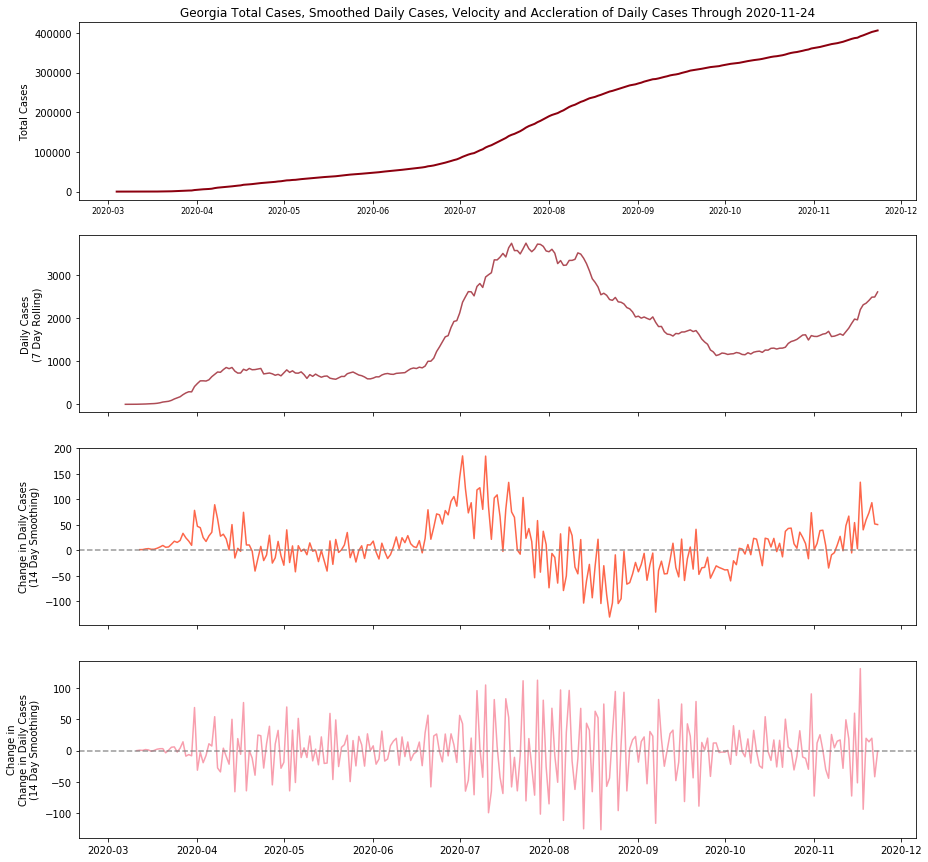

Hawaii returned 265 rows
Hawaii returned 265 rows


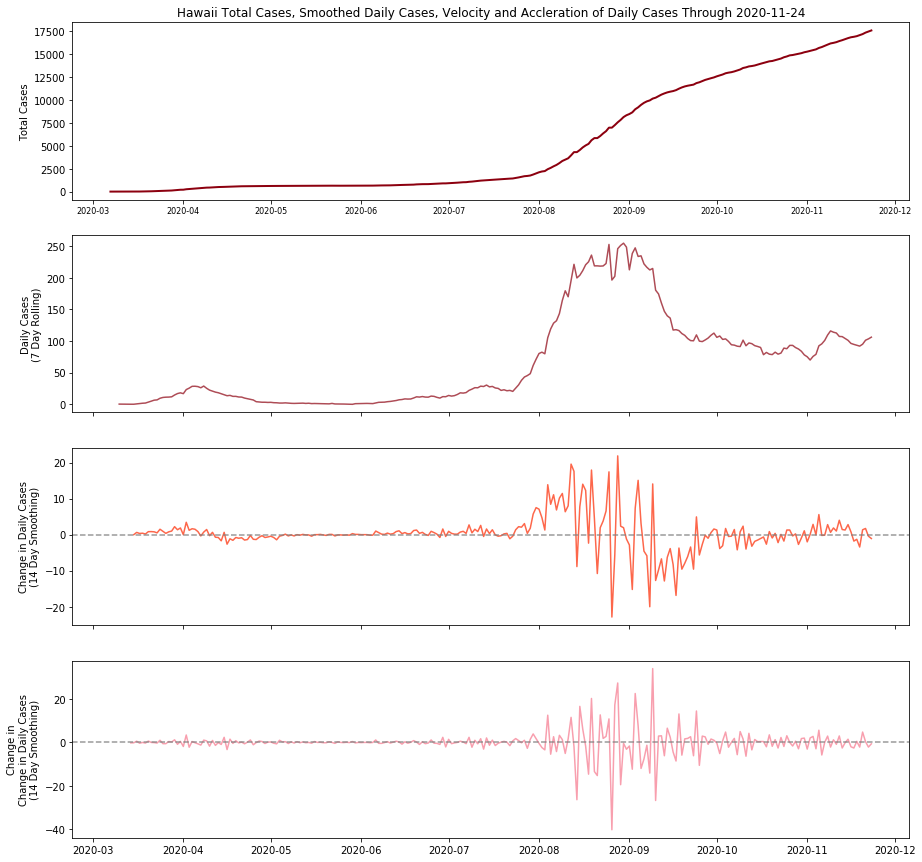

Idaho returned 262 rows
Idaho returned 262 rows


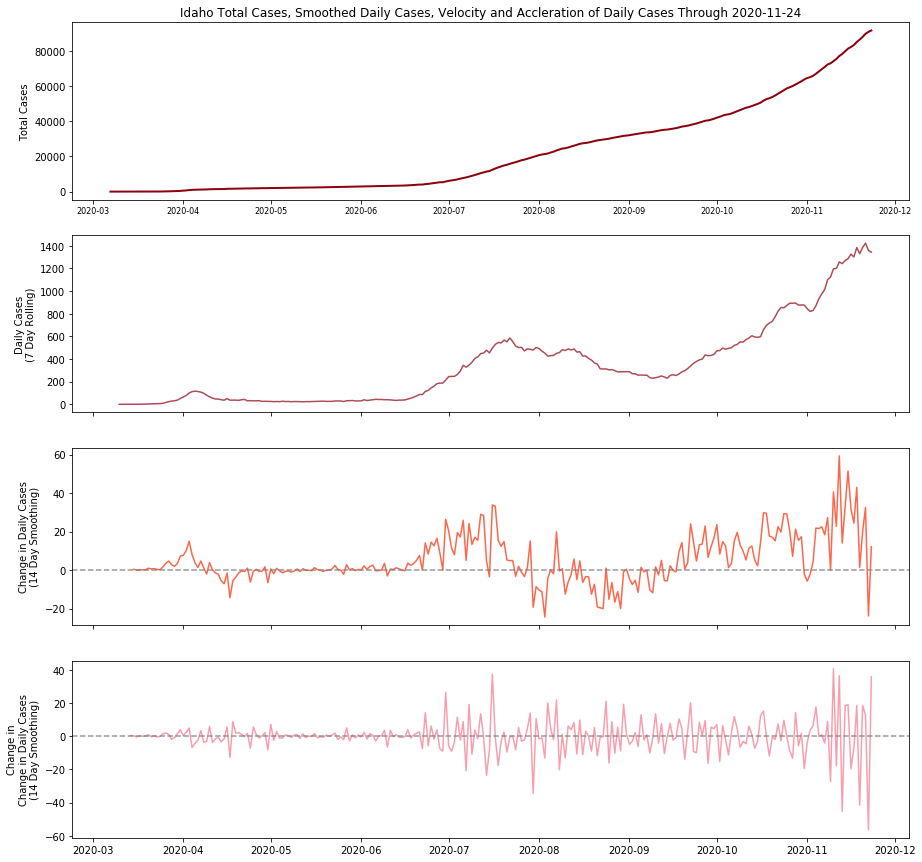

Illinois returned 265 rows
Illinois returned 265 rows


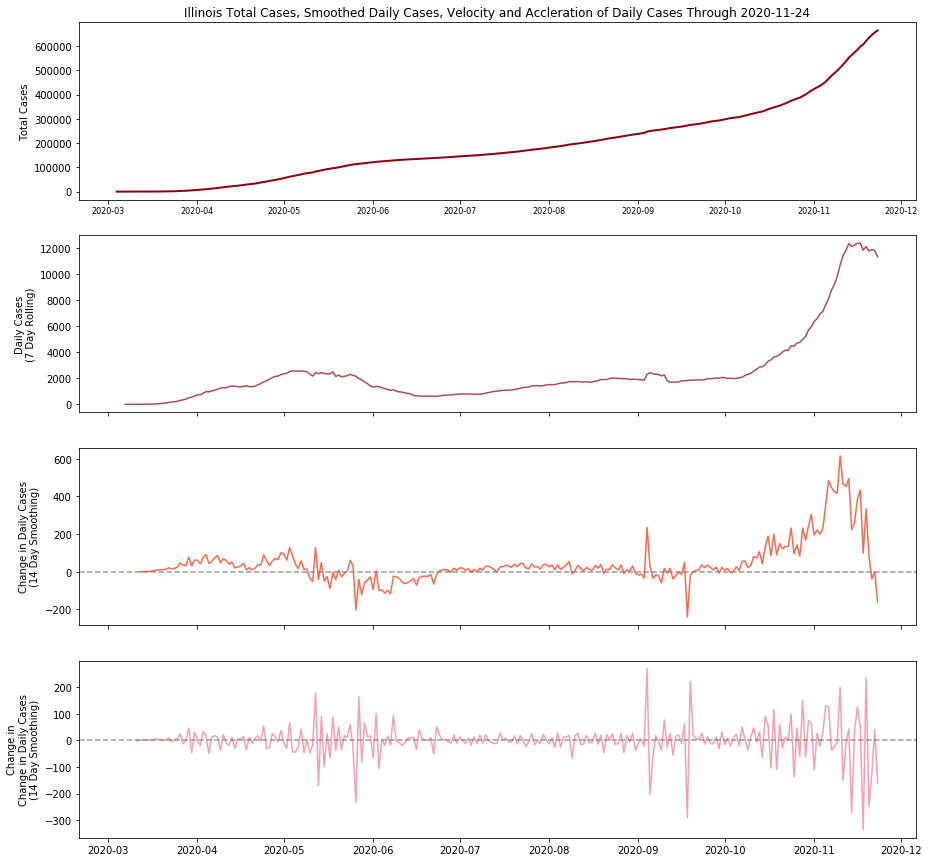

Indiana returned 271 rows
Indiana returned 271 rows


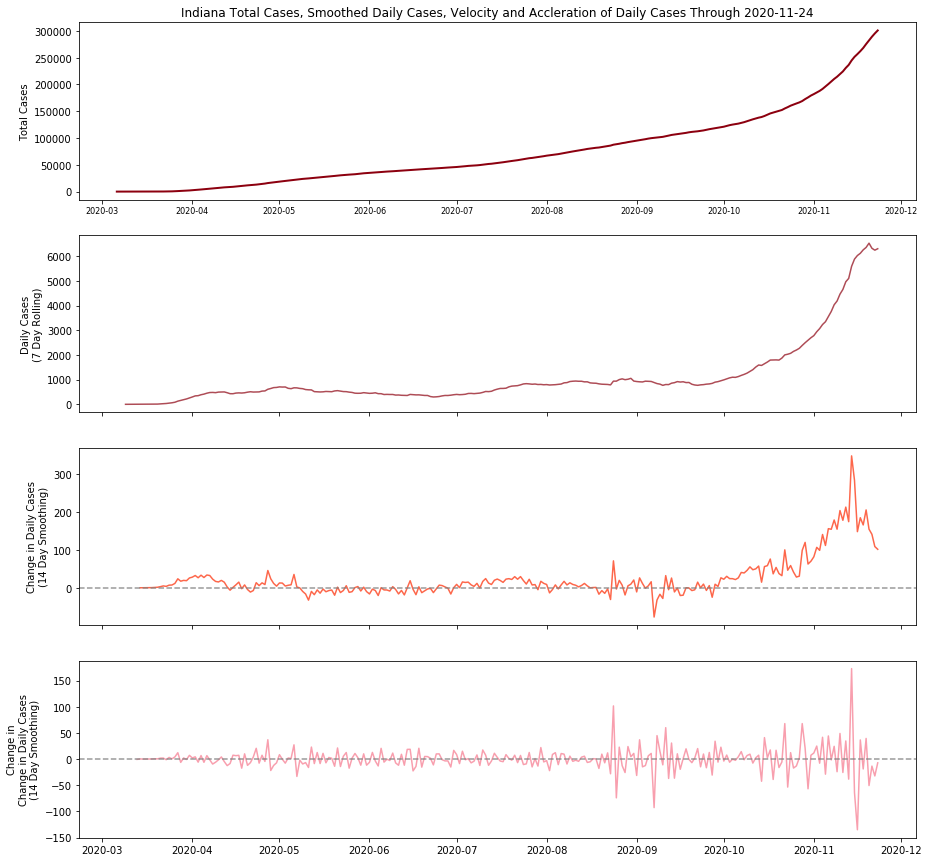

Iowa returned 263 rows
Iowa returned 263 rows


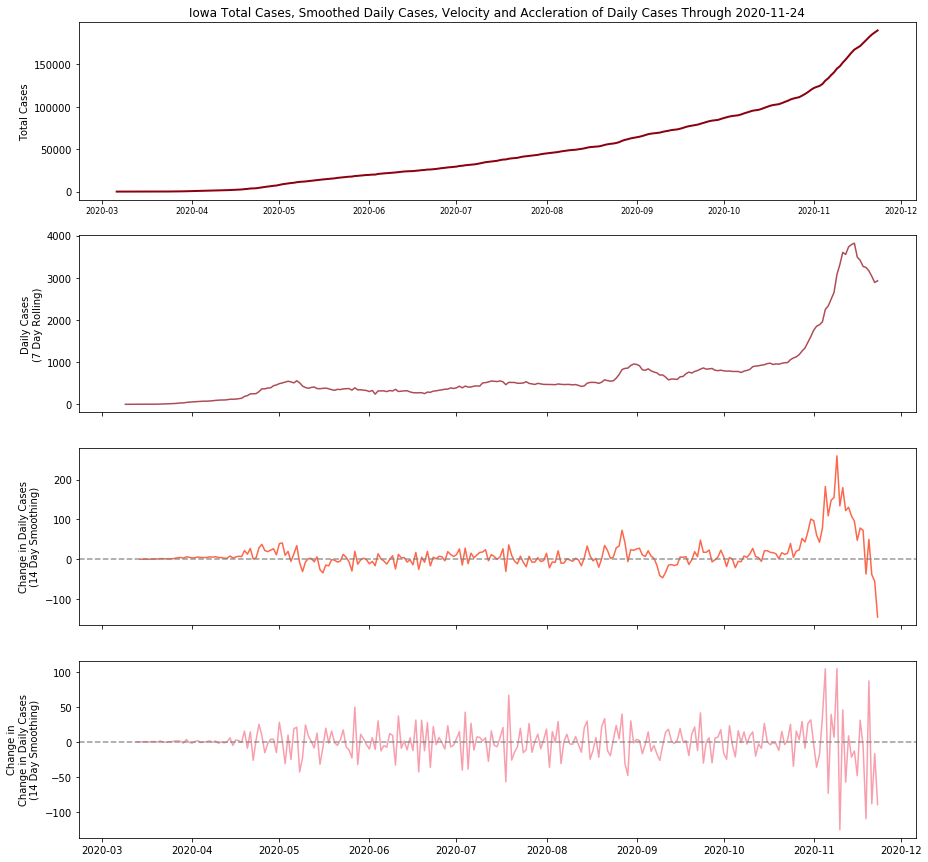

Kansas returned 263 rows
Kansas returned 263 rows


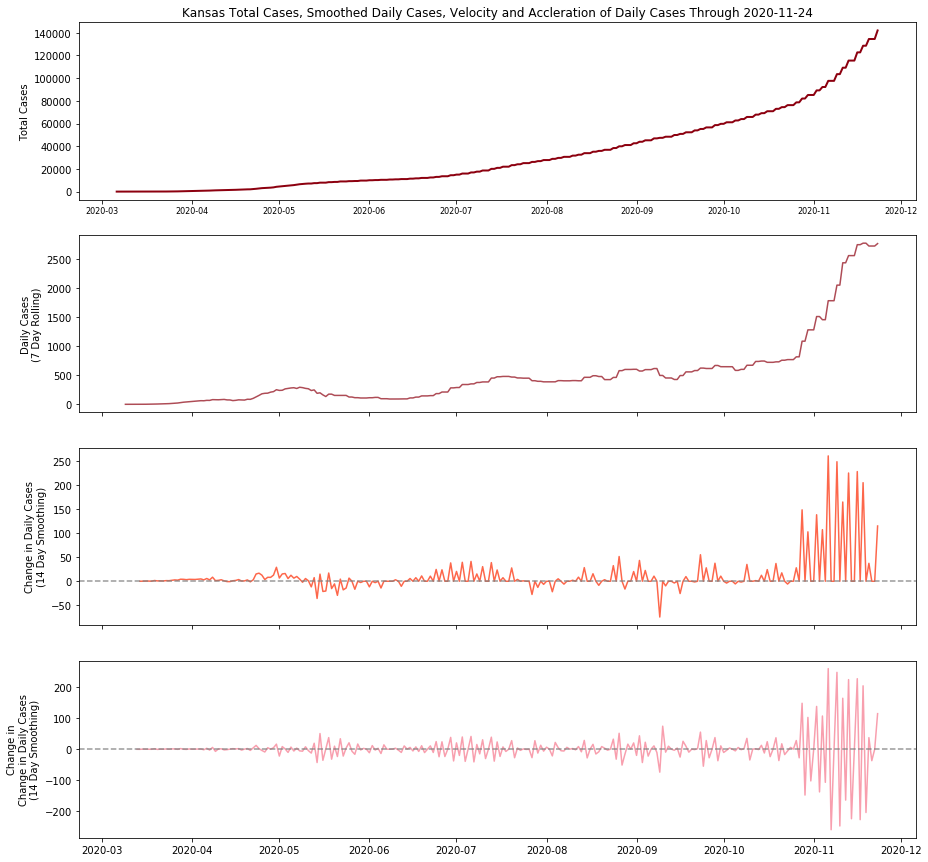

Kentucky returned 263 rows
Kentucky returned 263 rows


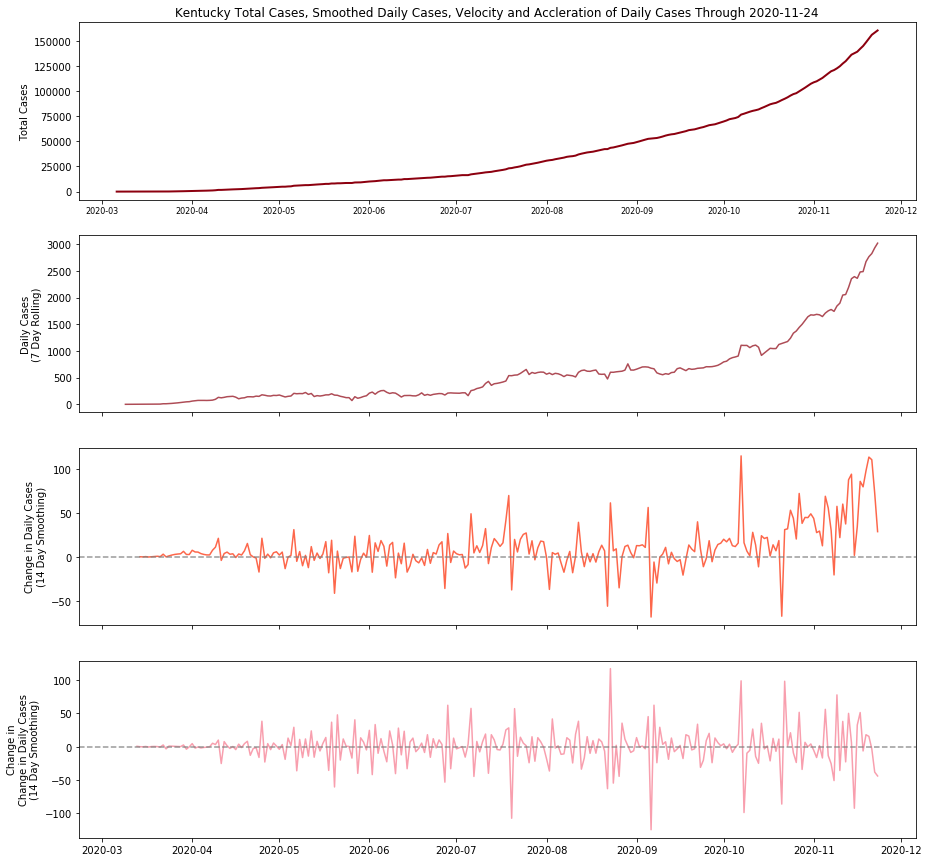

Louisiana returned 262 rows
Louisiana returned 262 rows


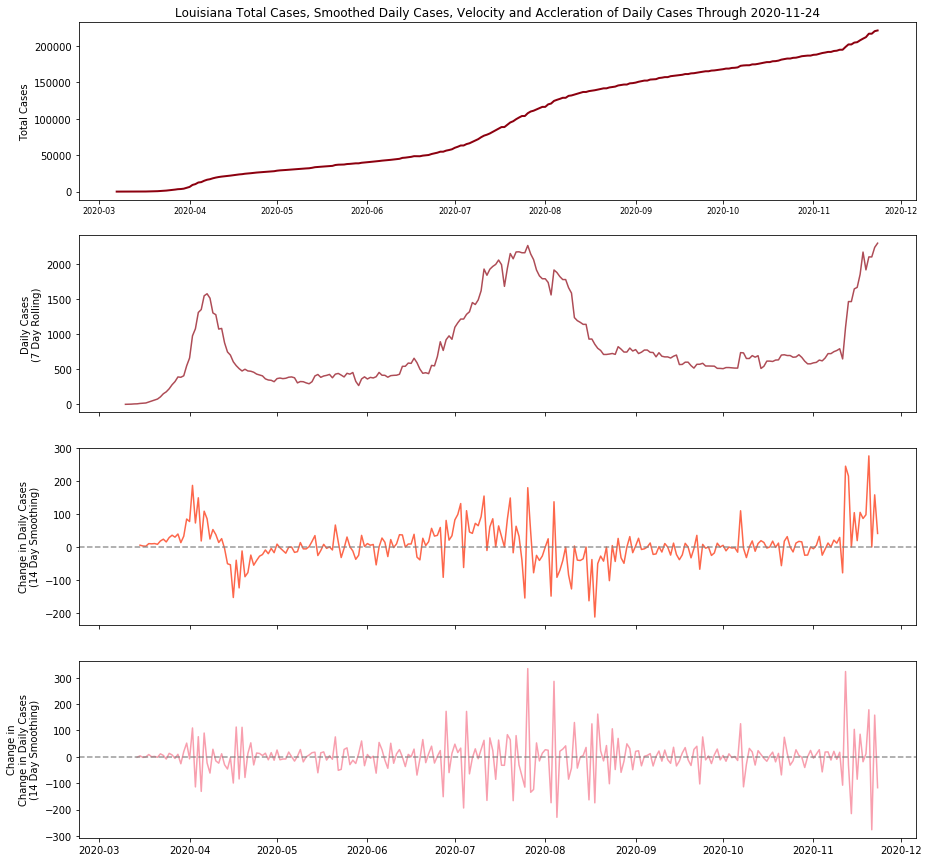

Maine returned 262 rows
Maine returned 262 rows


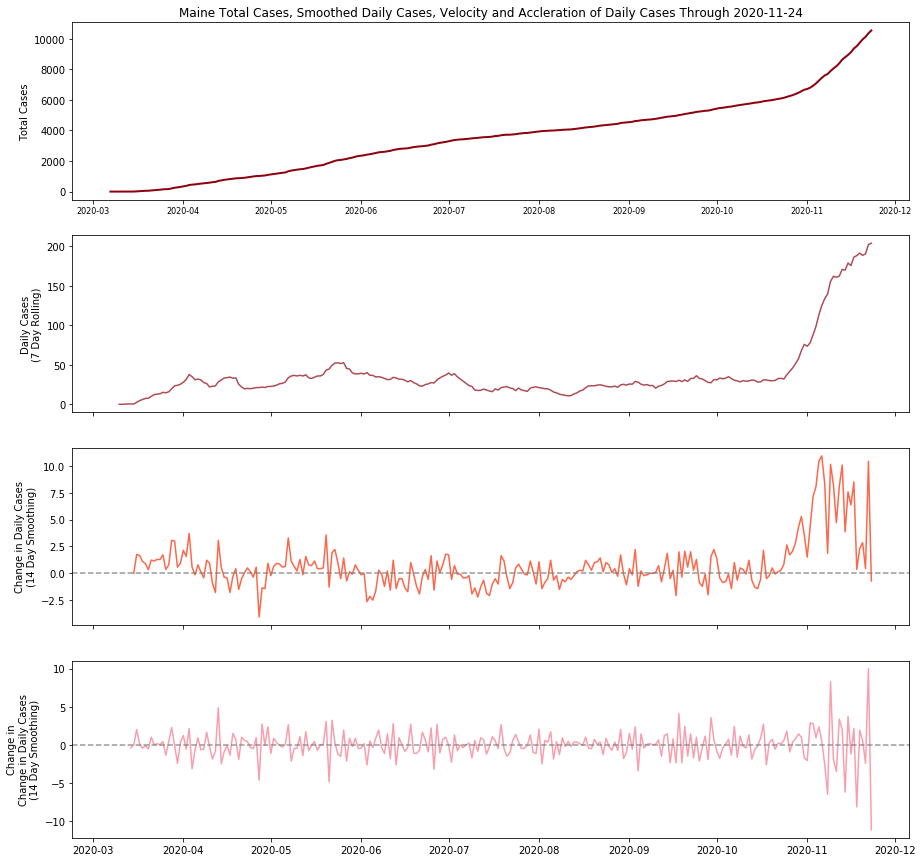

Maryland returned 264 rows


SystemError: <built-in method write of _io.BufferedWriter object at 0x7fd9e36da890> returned a result with an error set

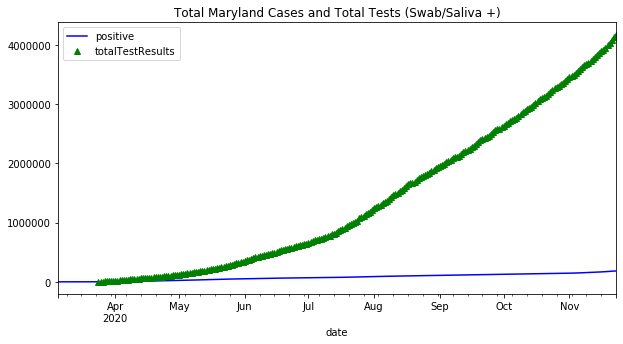

In [160]:
states_data = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv')
for state in states[::-1]:
    state_plots(state, get_state_data(state, states_data))
    daily_w_velocity(state, get_state_data(state, states_data))

In [188]:
def daily_w_velocity(state, df, close = True, save = True):
        # Return path and today's date as string
        path_for_charts, TODAY = get_folder_name()
        _plot, axs = plt.subplots(4,1,figsize=(15,15))
        axs[0] = plt.subplot(411)
        plt.plot(df.index, df['positive'], color='xkcd:crimson', alpha=1.0, linewidth=2)
        #plt.setp(ax1.get_xticklabels(), visible=False)
        axs[0].set_ylabel('Total Cases')
        plt.setp(ax[0].get_xticklabels(), fontsize=8)
        plt.title(f'{state} Total Cases, Smoothed Daily Cases, Velocity and Accleration of Daily Cases Through {TODAY}')


        axs[1] = plt.subplot(412, sharex=axs[0])
        plt.plot(df.index, df['Daily Positive'].rolling(window=7, min_periods=3).mean(), color='xkcd:crimson', alpha=0.7)
        plt.setp(axs[1].get_xticklabels(), visible=False)
        axs[1].set_ylabel('Daily Cases\n(7 Day Rolling)')

        axs[2] = plt.subplot(413, sharex=axs[0])
        plt.plot(df.index, df['Velocity of Daily Cases'].rolling(window=14, min_periods=7).mean(),color='xkcd:orange red', alpha=0.8)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.8)
        plt.setp(axs[2].get_xticklabels(), visible=False)
        axs[2].set_ylabel('Change in Daily Cases\n(14 Day Smoothing)')


        axs[3] = plt.subplot(414, sharex=axs[0])
        plt.plot(df.index, df['Acceleration of Daily Cases'].rolling(window=14, min_periods=5).mean(),color='xkcd:rose pink', alpha=0.8)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.8)
        axs[3].set_ylabel('Change in\nChange in Daily Cases\n(14 Day Smoothing)')

        if save:
            _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Velocity and Accleration of Daily Cases {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
        if close:
            plt.close()
        

New Jersey returned 288 rows


NameError: name 'ax' is not defined

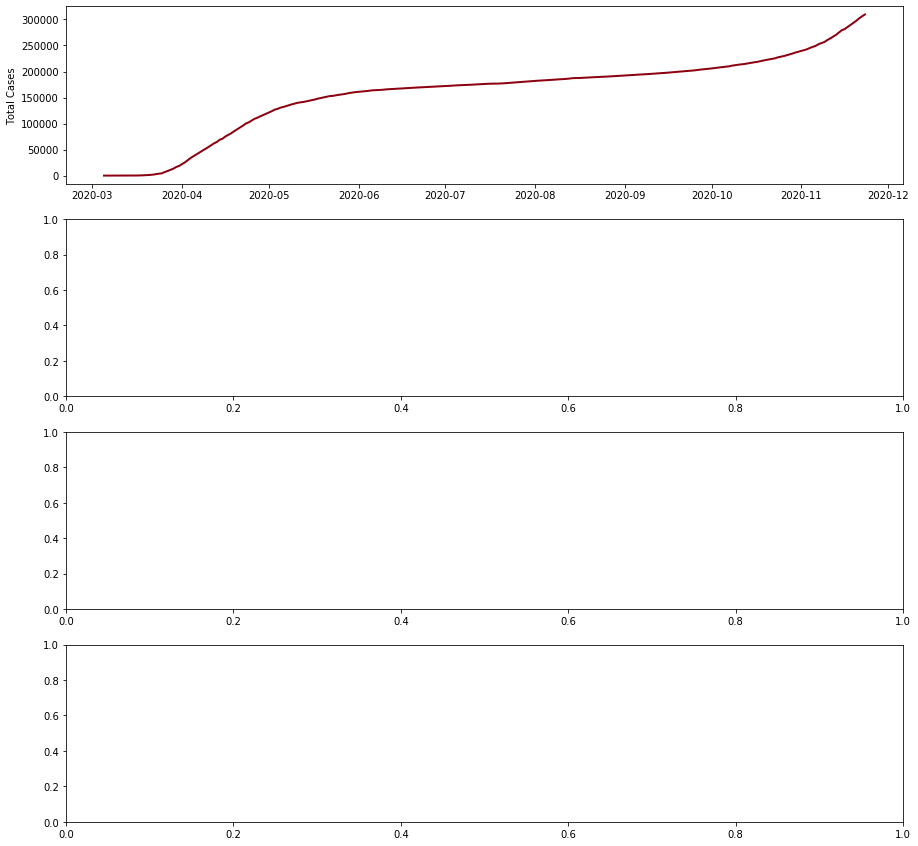

In [189]:
daily_w_velocity('New Jersey', get_state_data('New Jersey', states_data), close=True, save=True)